In [39]:
from typing import Optional, Type, Callable
import torch

def named_apply(fn: Callable, module: torch.nn.Module, name="", depth_first=True, include_root=False) -> torch.nn.Module:
    if not depth_first and include_root:
        fn(module=module, name=name)
    for child_name, child_module in module.named_children():
        child_name = ".".join((name, child_name)) if name else child_name
        named_apply(fn=fn, module=child_module, name=child_name, depth_first=depth_first, include_root=True)
    if depth_first and include_root:
        fn(module=module, name=name)
    return module

def init_weights_vit_timm(module: torch.nn.Module, name: str = ""):
    """ViT weight initialization, original timm impl (for reproducibility)"""
    if isinstance(module, torch.nn.Linear):
        torch.nn.init.trunc_normal_(module.weight, std=0.02)
        if module.bias is not None:
            torch.nn.init.zeros_(module.bias)

def extend_valid_token_mask(
    valid_token_mask: Optional[torch.Tensor], num_registers: int
) -> Optional[torch.Tensor]:
    """
    Extends the valid token mask to include the register tokens.

    Parameters:
    - valid_token_mask (B, N): The original valid token mask.

    Returns:
    - extended_valid_token_mask (B, N + R): The extended valid token mask.
    """
    if valid_token_mask is None:
        return None
    return torch.cat(
        [
            valid_token_mask,
            torch.ones(
                valid_token_mask.shape[0],
                num_registers,
                dtype=torch.bool,
                device=valid_token_mask.device,
            ),
        ],
        dim=1,
    )

class MLPBlock(torch.nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int,
        num_layers: int,
        act_layer: Type[torch.nn.Module],
    ) -> None:
        super().__init__()
        h = [hidden_dim] * (num_layers - 1)
        self.layers = torch.nn.ModuleList(
            torch.nn.Sequential(torch.nn.Linear(n, k), act_layer())
            for n, k in zip([input_dim] + h, [hidden_dim] * num_layers)
        )
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.fc(x)

class Block(torch.nn.Module):
    def __init__(
        self,
        dim: int,
        num_heads: int,
        act_layer: Type[torch.nn.Module],
        mlp_dim: Optional[int] = None,
    ) -> None:
        super().__init__()

        if mlp_dim is None:
            mlp_dim = 4 * dim

        self.norm1 = torch.nn.LayerNorm(dim)
        self.norm2 = torch.nn.LayerNorm(dim)
        self.attn = torch.nn.MultiheadAttention(
            embed_dim=dim, num_heads=num_heads, batch_first=True
        )
        self.mlp = MLPBlock(
            input_dim=dim,
            hidden_dim=mlp_dim,
            output_dim=dim,
            num_layers=1,
            act_layer=act_layer,
        )

    def forward(
        self, x: torch.Tensor, invalid_token_mask: Optional[torch.Tensor]
    ) -> torch.Tensor:
        shortcut = x
        x = self.norm1(x)

        x = self.attn(x, x, x, key_padding_mask=invalid_token_mask)[0]
        x = shortcut + x

        x = x + self.mlp(self.norm2(x))
        return x

class ImageEncoder(torch.nn.Module):
    def __init__(
        self,
        num_tokens: int,
        num_registers: int,
        patch_size: int,
        depth: int,
        embedding_dim: int,
        num_heads: int,
        act_layer: Type[torch.nn.Module],
    ):
        super().__init__()

        self.patch_emb = torch.nn.Linear(patch_size * patch_size * 3, embedding_dim)

        self.pos_enc = torch.nn.Parameter(torch.randn(num_tokens, embedding_dim))

        self.reg_tokens = torch.nn.Parameter(torch.randn(num_registers, embedding_dim))

        self.blocks = torch.nn.ModuleList()

        for _ in range(depth):
            self.blocks.append(
                Block(
                    dim=embedding_dim,
                    num_heads=num_heads,
                    act_layer=act_layer,
                )
            )

        self.init_weights()

    @property
    def embed_dim(self) -> int:
        return self.patch_emb.out_features

    def init_weights(self):
        torch.nn.init.trunc_normal_(self.pos_enc, std=0.02)
        torch.nn.init.normal_(self.reg_tokens, std=1e-6)
        named_apply(init_weights_vit_timm, self)

    def forward(
        self, foveated_tokens: torch.Tensor, valid_token_mask: Optional[torch.Tensor]
    ) -> torch.Tensor:
        """
        Parameters:
        - foveated_tokens (B, N, E): The input foveated image tokens.
        - valid_token_mask (B, N): An optional mask indicating which tokens are valid.

        Returns:
        - features (B, N, C): The output feature vectors, one per input token
        - register_features (B, N, C): The register feature vectors, one per register token
        """
        embedded_tokens = self.patch_emb(
            foveated_tokens.flatten(2)
        ) + self.pos_enc.unsqueeze(0)

        num_registers = self.reg_tokens.shape[0]

        embedded_tokens = torch.cat(
            [
                embedded_tokens,
                self.reg_tokens.unsqueeze(0).expand(embedded_tokens.shape[0], -1, -1),
            ],
            dim=1,
        )

        valid_token_mask = extend_valid_token_mask(valid_token_mask, num_registers)

        invalid_token_mask = (
            valid_token_mask.logical_not() if valid_token_mask is not None else None
        )

        transformed_tokens = embedded_tokens
        for block in self.blocks:
            transformed_tokens = block(transformed_tokens, invalid_token_mask)

        features = transformed_tokens #self.neck(transformed_tokens)

        return features.split([features.shape[1] - num_registers, num_registers], dim=1)

def create_vit_b(num_tokens, patch_size) -> ImageEncoder:
    return ImageEncoder(
        num_tokens=num_tokens,
        num_registers=1,
        patch_size=patch_size,
        depth=12,
        embedding_dim=768,
        num_heads=12,
        act_layer=torch.nn.ReLU,
    )



In [40]:
def create_vit(num_tokens, patch_size) -> ImageEncoder:
    return ImageEncoder(
        num_tokens=num_tokens,
        num_registers=1,
        patch_size=patch_size,
        depth=12,
        embedding_dim=768,
        num_heads=12,
        act_layer=torch.nn.ReLU,
    )

In [59]:
from typing import List, Optional, Tuple
from itertools import islice
import torch
import einops
from torchvision.ops import roi_align
from torchvision.transforms import Resize
import abc

def is_monotonically_increasing(vals: List[int]) -> bool:
    return all(y > x for x, y in zip(vals[:-1], vals[1:]))

def generate_grid_coords_2d(grid_size):
    x = torch.arange(grid_size)
    return torch.stack(torch.meshgrid(x, x, indexing="xy"), dim=-1)

def denormalize_keypoints(
    keypoints: torch.Tensor, image_size: tuple[int, int]
) -> torch.Tensor:
    """
    Arguments:
        keypoints: Tensor of shape (..., 2)
            where the last dimension contains (x, y) coordinates of keypoints.
        image_size: Tuple (height, width) of the image.
    Denormalize keypoints from [-1, 1] range to pixel coordinates based on image size.
    """
    height, width = image_size
    return torch.stack(
        [
            ((keypoints[..., 0] + 1) / 2) * width,  # Denormalize x to pixel coordinates
            ((keypoints[..., 1] + 1) / 2) * height,  # Denormalize y to pixel coordinates
        ],
        dim=-1,
    )

def batched_crop(images: torch.Tensor, crop_bounds: torch.Tensor, out_shape: tuple) -> torch.Tensor:
    """
    Crops images based on the provided crop bounds and resizes them to the specified output shape.
    Args:
        images (torch.Tensor): Input images of shape [B, C, H, W].
        crop_bounds (torch.Tensor): Crop bounds of shape [B, 2, 2], where each entry is [[x1, y1], [x2, y2]].
        out_shape (tuple): Desired output shape for the cropped images, e.g., (H_out, W_out).
    Returns:
        torch.Tensor: Cropped and resized images of shape [B, C, H_out, W_out].
    """
    B = crop_bounds.shape[0]
    batch_indices = torch.arange(B, device=crop_bounds.device, dtype=crop_bounds.dtype).unsqueeze(1)

    # Concatenate batch index with crop coordinates
    boxes = torch.cat([
        batch_indices,                      # (B, 1)
        crop_bounds[:, 0, 0:1],            # x1
        crop_bounds[:, 0, 1:2],            # y1
        crop_bounds[:, 1, 0:1],            # x2
        crop_bounds[:, 1, 1:2],            # y2
    ], dim=1)  # (B, 5)

    return roi_align(images, boxes, output_size=out_shape, aligned=True)

def get_crop_bounds(center: torch.Tensor, crop_size: int) -> torch.Tensor:
    """
    Calculates the lower and upper bounds for cropping an image centered around a given point.
    Args:
        center (torch.Tensor): The center point for the crop, shape [B, 2].
        crop_size (int): The size of the crop to be applied.
    Returns:
        torch.Tensor: A tensor containing the lower and upper corners of the crop, shape [B, 2, 2].
    """
    lower_corner = (center - crop_size / 2).floor()
    upper_corner = lower_corner + crop_size
    return torch.stack([lower_corner, upper_corner], dim=1)  

def compute_integral_image(image: torch.Tensor):
    """
    Computes the integral image of the given input image.
    The integral image is computed by cumulatively summing the pixel values along both dimensions.
    Args:
        image (torch.Tensor): Input image tensor of shape [B, C, H, W].
    Returns:
        torch.Tensor: The integral image tensor of shape [B, C, H, W].
    """
    padded = torch.nn.functional.pad(image, (1, 0, 1, 0), mode="constant", value=0)
    return padded.cumsum(dim=3).cumsum(dim=2)

class BatchedFoveator(torch.nn.Module):
    """
    A batched version of the Foveator class that allows for processing multiple images in a batch.
    This class extends the Foveator class and overrides the extract_foveated_image method to handle batches.
    """
    def __init__(
        self, token_size: int, strides: List[int], grid_sizes: List[int]
    ) -> None:
        """
        Initializes the Foveator module, which is used to extract and reconstruct foveated images.

        Parameters:
        - token_size (int): The size of each token in the foveated image.
        - strides (List[int]): A list of stride values for each level of foveation. Must be monotonically increasing.
        - grid_sizes (List[int]): A list of grid sizes corresponding to each level of foveation. Must have the same length as strides.

        Raises:
        - ValueError: If the lengths of strides and grid_sizes do not match, or if they do not lead to monotonically increasing block sizes, or if they do not allow for nestable block sizes.
        """

        super().__init__()

        num_levels = len(strides)
        if len(grid_sizes) != num_levels:
            raise ValueError(
                "[Foveator]: Constructor arguments 'strides' and 'grid_sizes' must have the same length."
            )

        if not is_monotonically_increasing(strides):
            raise ValueError(
                "[Foveator]: Constructor agrument 'strides' should have monotonically increasing values."
            )

        # Block sizes are in multiples of stride-1 tokens.
        self.block_sizes = [
            stride * grid_size for stride, grid_size in zip(strides, grid_sizes)
        ]
        if not is_monotonically_increasing(self.block_sizes):
            raise ValueError(
                "[Foveator]: Constructor arguments 'strides' and 'grid_sizes' do not lead to monotonically increasing block sizes."
            )

        token_corner_indices_by_level = []

        self.ring_thickness_tokens = [None]

        for level_index, (stride, grid_size, block_size) in enumerate(
            zip(strides, grid_sizes, self.block_sizes)
        ):
            grid_coords = generate_grid_coords_2d(grid_size)
            offset = (self.block_sizes[-1] - block_size) // 2
            if level_index == 0:
                token_corner_indices_by_level.append(
                    offset + stride * grid_coords.flatten(0, 1)
                )
                continue

            prior_block_size = self.block_sizes[level_index - 1]
            redundant_grid_size = prior_block_size // stride
            if stride * redundant_grid_size != prior_block_size:
                raise ValueError(
                    "[Foveator]: Constructor arguments 'strides' and 'grid_sizes' do not lead to nestable block sizes."
                )
            ring_thickness_tokens = (grid_size - redundant_grid_size) // 2
            if ring_thickness_tokens * 2 + redundant_grid_size != grid_size:
                raise ValueError(
                    "[Foveator]: Constructor arguments 'strides' and 'grid_sizes' do not lead to evenly nestable block sizes."
                )
            # upper rows, include all columns
            level_corner_indices = [grid_coords[:ring_thickness_tokens].flatten(0, 1)]
            # central rows, exclude already-covered central columns
            for row in grid_coords[ring_thickness_tokens:-ring_thickness_tokens]:
                level_corner_indices.append(row[:ring_thickness_tokens])
                level_corner_indices.append(row[-ring_thickness_tokens:])
            # lower rows, include all columns
            level_corner_indices.append(
                grid_coords[-ring_thickness_tokens:].flatten(0, 1)
            )

            token_corner_indices_by_level.append(
                offset + stride * torch.cat(level_corner_indices)
            )

            self.ring_thickness_tokens.append(ring_thickness_tokens)

        self.token_size = token_size
        self.strides_by_level = strides
        self.grid_sizes_by_level = grid_sizes
        self.num_tokens_by_level = [
            len(corners) for corners in token_corner_indices_by_level
        ]
        self.register_buffer(
            "token_corner_indices",
            token_size * torch.cat(token_corner_indices_by_level),
            persistent=False,
        )
        self.register_buffer(
            "token_strides",
            torch.cat(
                [
                    torch.full((len(corners),), stride)
                    for corners, stride in zip(token_corner_indices_by_level, strides)
                ]
            ),
        )
        self.register_buffer(
            "grid_coords_2d",
            generate_grid_coords_2d(
                self.token_size
            ).unsqueeze(0)
        )

    def get_pattern_bounds_size(self) -> int:
        return self.block_sizes[-1] * self.token_size

    def get_num_tokens(self) -> int:
        return len(self.token_strides)

    def extract_foveated_image(self, images: torch.Tensor) -> torch.Tensor:
        """
        # This function extracts a set of tokens representing a foveated version of the input image.
        # Input: images (Tensor of shape [B, C, H, W]).
        # Output: foveated tokens (Tensor of shape [B, N, C, H, W])
        """
        if not images.ndim == 4:
            raise ValueError(
                "[Foveator.extract_foveated_image]: Expected 3D input Tensor."
            )

        expected_input_size = self.token_size * self.block_sizes[-1]
        if (
            images.shape[-2] != expected_input_size
            or images.shape[-1] != expected_input_size
        ):
            raise ValueError(
                f"[Foveator.extract_foveated_image]: Expected square image of size {expected_input_size}"
            )
        if images.shape[-3] != 3:
            raise ValueError(
                f"[Foveator.extract_foveated_image]: Expected 3-channel image."
            )
                
        integral_image = compute_integral_image(images) # (B, C, H, W)

        # self.token_corner_indices is (N, U)
        # self.token_strides is (N)
        # generate_grid_coords_2d return (H, W, U)
        # All get mapped to (N, H, W, U)
        lower_pixel_coords = self.token_corner_indices.view(
            -1, 1, 1, 2
        ) + self.token_strides.view(-1, 1, 1, 1) * self.grid_coords_2d
        upper_pixel_coords = lower_pixel_coords + self.token_strides.view(-1, 1, 1, 1)

        B, C, H, W = integral_image.shape
        N, I1, I2, _ = lower_pixel_coords.shape

        # Convert (y, x) to flat indices: flat_idx = y * W + x
        def to_flat_indices(coords):
            return coords[..., 1] * W + coords[..., 0]  # shape: (N, I1, I2)

        # Flatten spatial dimensions of integral image
        flat_integral = integral_image.view(B, C, H * W)

        # Compute flat indices
        lu = to_flat_indices(upper_pixel_coords)  # top-left
        ru = to_flat_indices(torch.stack([lower_pixel_coords[..., 0], upper_pixel_coords[..., 1]], dim=-1))  # top-right
        ld = to_flat_indices(torch.stack([upper_pixel_coords[..., 0], lower_pixel_coords[..., 1]], dim=-1))  # bottom-left
        rd = to_flat_indices(lower_pixel_coords)  # bottom-right

        # Shape: (B, N, C, I1, I2) → make it (B, C, N * I1 * I2)
        def gather_flat(flat_idx):
            flat_idx = flat_idx.view(1, 1, -1).expand(B, C, -1)  # (B, C, N * I1 * I2)
            x = flat_integral.gather(2, flat_idx).view(B, C, N, I1, I2)
            return einops.rearrange(x, "B C N I1 I2 -> B N C I1 I2")

        return (
            gather_flat(rd)
            + gather_flat(lu)
            - gather_flat(ru)
            - gather_flat(ld)
        ) / self.token_strides.square().view(1, -1, 1, 1, 1).float()

    def get_in_bounds_tokens(
        self,
        image_size: torch.Tensor,           
        crop_bounds: torch.Tensor,         
        in_bounds_threshold: float = 0.0,
    ) -> torch.Tensor:
        """
        Returns a binary mask indicating which tokens are sufficiently in bounds to be considered valid.
        
        Args:
            image_size: Tensor of shape [2], the size of the input image (width, height).
            crop_bounds: Tensor of shape [B, 2, 2], where each entry is [[x1, y1], [x2, y2]] for each batch.
            in_bounds_threshold: Minimum fraction of token area that must be in bounds.
            
        Returns:
            valid_token_mask: Tensor of shape [B, N] indicating valid tokens per batch element.
        """
        device = crop_bounds.device
        image_size = image_size.to(device)

        # (B, N, 2) = (1, N, 2) + (B, 1, 2)
        foveation_offset = crop_bounds[:, 0]  # (B, 2)
        token_corner_coordinates = self.token_corner_indices[None, :, :] + foveation_offset[:, None, :]  # (B, N, 2)

        bounded_lower_corners = token_corner_coordinates.clamp(min=0)
        bounded_upper_corners = torch.minimum(
            token_corner_coordinates + self.token_size * self.token_strides.view(1, -1, 1),  # (1, N, 2)
            image_size.view(1, 1, 2),
        )

        area_per_pixel = self.token_strides.square()  # (N,)
        in_bounds_area = (
            (bounded_upper_corners - bounded_lower_corners).clamp(min=0).prod(dim=-1).float()
        )  # (B, N)

        valid_token_mask = (in_bounds_area / area_per_pixel.float()) > in_bounds_threshold  # (B, N)
        return valid_token_mask
    
    def generate_foveated_visualization(self, tokens: torch.Tensor, draw_lines: bool = True) -> torch.Tensor:
        """
        # This function reconstructs an image given a set of foveated tokens.
        # Input: foveated tokens (Tensor of shape [N, C, H, W]).
        # Output: image (Tensor of shape [C, H, W])
        """
        if not tokens.ndim == 4:
            raise ValueError(
                "[Foveator.generate_foveated_visualization]: Expected 4D input Tensor (N, C, H, W)."
            )
        if tokens.shape[0] != len(self.token_strides):
            raise ValueError(
                f"[Foveator.generate_foveated_visualization]: Expected {len(self.token_strides)} tokens"
            )
        if tokens.shape[-2] != self.token_size or tokens.shape[-1] != self.token_size:
            raise ValueError(
                f"[Foveator.generate_foveated_visualization]: Expected square tokens of size {self.token_size}"
            )

        C = tokens.shape[1]
        reconstruction_size = self.block_sizes[-1] * self.token_size

        reconstructed_image = torch.empty((C, reconstruction_size, reconstruction_size))

        tokens_by_level = torch.split(tokens, self.num_tokens_by_level)

        # insert the innermost block

        # unflatten | N, C, H, W     ->  I, J, C, H, W
        # permute   | I, J, C, H, W  ->  C, I, H, J, W
        # flatten   | C, I, H, J, W  ->  C, H, W
        inner_block = (
            tokens_by_level[0]
            .unflatten(0, (self.grid_sizes_by_level[0], self.grid_sizes_by_level[0]))
            .permute(2, 0, 3, 1, 4)
            .flatten(3, 4)
            .flatten(1, 2)
        )
        if draw_lines:
            inner_block[:, -1:, :] = 1.0
            inner_block[:, :, -1:] = 1.0

        offset = self.token_size * (self.block_sizes[-1] - self.block_sizes[0]) // 2

        reconstructed_image[:, offset:-offset, offset:-offset] = inner_block

        # build up the reconstruction ring by ring
        for tokens, stride, grid_size, block_size, ring_thickness in islice(
            zip(
                tokens_by_level,
                self.strides_by_level,
                self.grid_sizes_by_level,
                self.block_sizes,
                self.ring_thickness_tokens,
            ),
            1,
            None,
        ):
            upsampled_tokens = tokens.repeat_interleave(stride, -1).repeat_interleave(
                stride, -2
            )

            if draw_lines:
                upsampled_tokens[:, :, -1:, :] = 1.0  # Draw horizontal lines
                upsampled_tokens[:, :, :, -1:] = 1.0  # Draw vertical lines

            row_height = upsampled_tokens.shape[-2]
            offset = self.token_size * (self.block_sizes[-1] - block_size) // 2
            i = 0
            for row in range(grid_size):
                if row < ring_thickness or row >= (grid_size - ring_thickness):
                    # these rows span the block width
                    reconstructed_image[
                        :,
                        offset + row * row_height : offset + (row + 1) * row_height,
                        offset : offset + self.token_size * block_size,
                    ] = (
                        upsampled_tokens[i : i + grid_size]
                        .permute(1, 2, 0, 3)
                        .flatten(2)
                    )
                    i += grid_size
                else:
                    # these rows are split in to by the higher-resolution center region
                    reconstructed_image[
                        :,
                        offset + row * row_height : offset + (row + 1) * row_height,
                        offset : offset + self.token_size * stride * ring_thickness,
                    ] = (
                        upsampled_tokens[i : i + ring_thickness]
                        .permute(1, 2, 0, 3)
                        .flatten(2)
                    )
                    i += ring_thickness
                    reconstructed_image[
                        :,
                        offset + row * row_height : offset + (row + 1) * row_height,
                        offset
                        + self.token_size
                        * stride
                        * (grid_size - ring_thickness) : offset
                        + self.token_size * block_size,
                    ] = (
                        upsampled_tokens[i : i + ring_thickness]
                        .permute(1, 2, 0, 3)
                        .flatten(2)
                    )
                    i += ring_thickness

        return reconstructed_image


class ImageTokenizer(abc.ABC):
    @abc.abstractmethod
    def tokenize(self, images: torch.Tensor, centers: torch.Tensor) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        pass

    @abc.abstractmethod
    def get_num_tokens(self) -> int:
        pass

    @abc.abstractmethod
    def get_token_size(self) -> int:
        pass

    @abc.abstractmethod
    def generate_visualization(self, tokens: torch.Tensor) -> torch.Tensor:
        pass

class BaseImageTokenizer(ImageTokenizer):
    def __init__(self, token_size: int = 16, height: int = 288, width: int = 288):
        assert height % token_size == 0, "Height must be divisible by token_size"
        assert width % token_size == 0, "Width must be divisible by token_size"
        self.token_size = token_size
        self.height = height
        self.width = width
        self.patch_height = height // token_size
        self.patch_width = width // token_size
        self.resize = Resize((height, width))

    def tokenize(self, images: torch.Tensor, centers: torch.Tensor = None) -> torch.Tensor:
        assert images.ndim == 4, "Input images must be a 4D tensor (B, C, H, W)"
        images = self.resize(images)
        patches = einops.rearrange(
            images,
            "B C (H1 H2) (W1 W2) -> B (H1 W1) C H2 W2",
            H1=self.patch_height,
            W1=self.patch_width,
            H2=self.token_size,
            W2=self.token_size,
        )
        masks = None
        return patches, masks
    
    def get_num_tokens(self) -> int:
        return self.patch_height * self.patch_width
    
    def get_token_size(self) -> int:
        return self.token_size
    
    def generate_visualization(self, tokens: torch.Tensor, draw_lines: bool = True) -> torch.Tensor:
        assert tokens.ndim == 4
        n, c, h, w = tokens.shape
        assert n == self.get_num_tokens(), "Number of tokens must match the expected number"
        assert c == 3, "Tokens must have 3 channels (RGB)"
        assert h == self.token_size, "Token height must match patch height"
        assert w == self.token_size, "Token width must match patch width"
        if draw_lines:
            tokens = tokens.clone()
            tokens[:, :, -1:, :] = 1.0  # Draw horizontal lines
            tokens[:, :, :, -1:] = 1.0  # Draw vertical lines
        return einops.rearrange(tokens, "(H1 W1) C H2 W2 -> C (H1 H2) (W1 W2)", H1=self.patch_height, W1=self.patch_width)

class FoveatedImageTokenizer(ImageTokenizer):
    def __init__(self, token_size: int = 16, strides: List[int] = [1, 2, 6], grid_sizes: List[int] = [2,3,3], height: int = 288, width: int = 288):
        self.foveator = BatchedFoveator(token_size=token_size, strides=strides, grid_sizes=grid_sizes)
        self.token_size = token_size
        self.strides = strides
        self.grid_sizes = grid_sizes
        self.height = height
        self.width = width
        self.resize = Resize((height, width))

    def tokenize(self, images: torch.Tensor, centers: torch.Tensor) -> torch.Tensor:
        assert images.ndim == 4, "Input images must be a 4D tensor (B, C, H, W)"
        images = self.resize(images)
        size = self.foveator.get_pattern_bounds_size()
        centers = denormalize_keypoints(centers, (self.height, self.width))
        crop_bounds = get_crop_bounds(centers, size)
        crops = batched_crop(images, crop_bounds, out_shape=(size, size))
        mask = self.foveator.get_in_bounds_tokens(
            torch.tensor([self.width, self.height], device=images.device),
            crop_bounds
        )
        patches = self.foveator.extract_foveated_image(crops)
        return patches, mask

    def get_num_tokens(self) -> int:
        return self.foveator.get_num_tokens()
    
    def get_token_size(self) -> int:
        return self.token_size
    
    def generate_visualization(self, tokens: torch.Tensor, draw_lines: bool = True) -> torch.Tensor:
        assert tokens.ndim == 4, "Tokens must be a 5D tensor (N, C, H, W)"
        return self.foveator.generate_foveated_visualization(tokens, draw_lines=draw_lines)


In [53]:
from gym_av_aloha.datasets.av_aloha_dataset import AVAlohaDataset
from torch.utils.data import DataLoader
#  create dataset
fps = 8.33333333333333
observation_indices = [0]
observation_timestamps = [i/fps for i in observation_indices]
delta_timestamps = {
    "observation.images.zed_cam_left": observation_timestamps,
    "left_eye": observation_timestamps,
}
dataset = AVAlohaDataset(
    repo_id="iantc104/av_aloha_sim", 
    delta_timestamps=delta_timestamps,
)

In [60]:
dataloader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=True,
    num_workers=0,
)

batch = next(iter(dataloader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.4253473e-05..1.0004883].


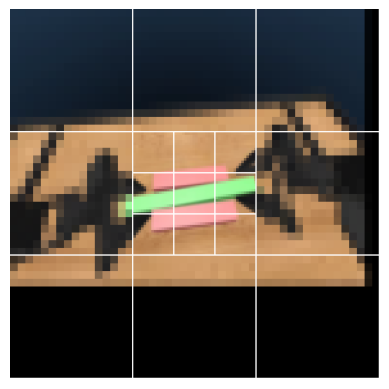

In [61]:
import matplotlib.pyplot as plt

images = batch["observation.images.zed_cam_left"].clone().squeeze(1)  # (B, C, H, W)
centers = batch["left_eye"].clone().squeeze(1)  # (B, 2)

tokenizer = FoveatedImageTokenizer(
    token_size=16, 
    strides=[1, 2, 6], 
    grid_sizes=[2,3,3],
    height=288,
    width=288,
)

# tokenizer = BaseImageTokenizer(
#     token_size=16, 
#     height=288,
#     width=288,
# )

tokens, masks = tokenizer.tokenize(images, centers)

visualization = tokenizer.generate_visualization(tokens[0])
plt.imshow(visualization.cpu().numpy().transpose(1, 2, 0))
plt.axis("off")
plt.show()

In [13]:
# tokenizer = FoveatedImageTokenizer(
#     token_size=16, 
#     strides=[1, 2, 6], 
#     grid_sizes=[2,3,3],
#     height=288,
#     width=288,
# )

tokenizer = BaseImageTokenizer(
    token_size=16, 
    height=288,
    width=288,
)

vit = create_vit(num_tokens=tokenizer.get_num_tokens(), patch_size=tokenizer.token_size)

images = batch["observation.images.zed_cam_left"].clone().squeeze(1)  # (B, C, H, W)
centers = batch["left_eye"].clone().squeeze(1)  # (B, 2)
tokens, masks = tokenizer.tokenize(images, centers)

vit(tokens, masks)[0].shape

torch.Size([64, 324, 768])

torch.Size([64, 3, 240, 320])


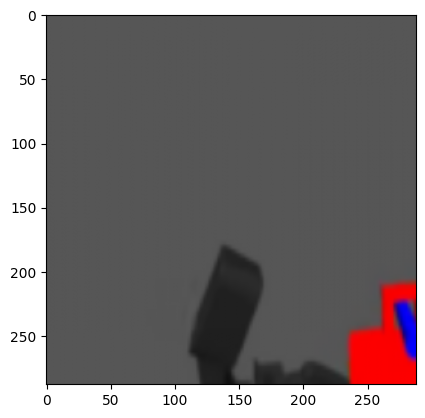

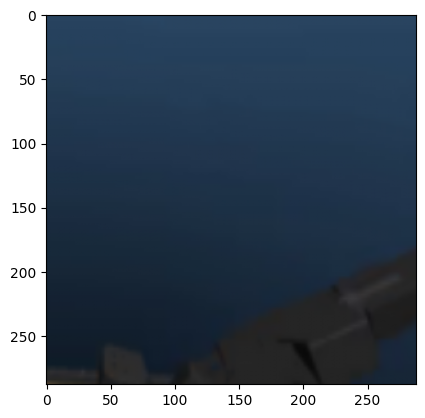

In [38]:
from gaze_av_aloha.policies.gaze_policy.utils import random_crop

images = batch["observation.images.zed_cam_left"].clone().squeeze(1)  # (B, C, H, W)
print(images.shape)
crop, _ = random_crop(images, 0.4, out_shape=(288, 288), random=True)
plt.imshow(crop[0].cpu().numpy().transpose(1, 2, 0))
plt.show()
plt.imshow(crop[1].cpu().numpy().transpose(1, 2, 0))
plt.show()